<a href="https://colab.research.google.com/github/us107/Book-Rating-predictions/blob/main/RatingsPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Ratings.csv')

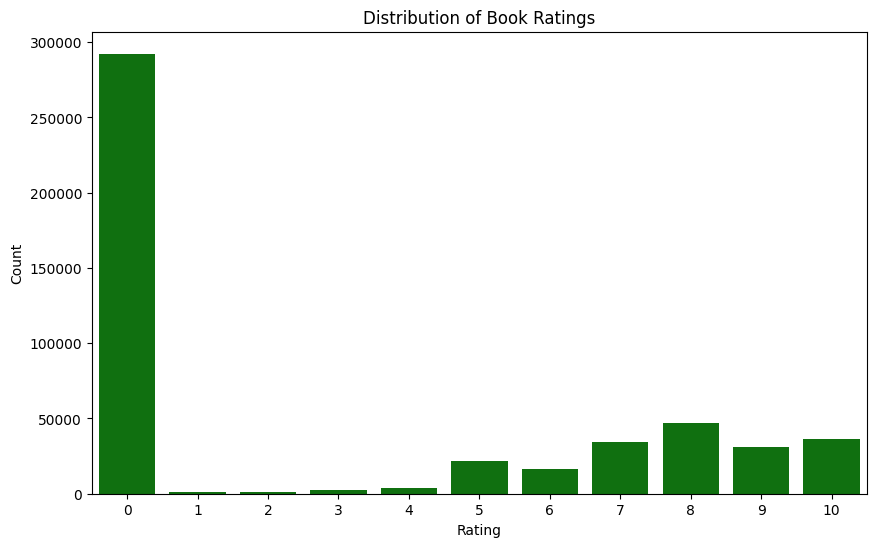

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Book-Rating',color='green')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [9]:
print('\
Rating Statistics:')
print(df['Book-Rating'].describe())

Rating Statistics:
count    488082.000000
mean          3.065180
std           3.922539
min           0.000000
25%           0.000000
50%           0.000000
75%           7.000000
max          10.000000
Name: Book-Rating, dtype: float64


User Activity Statistics:
Average ratings per user: 10.89
Median ratings per user: 1.0
Max ratings by a single user: 13602


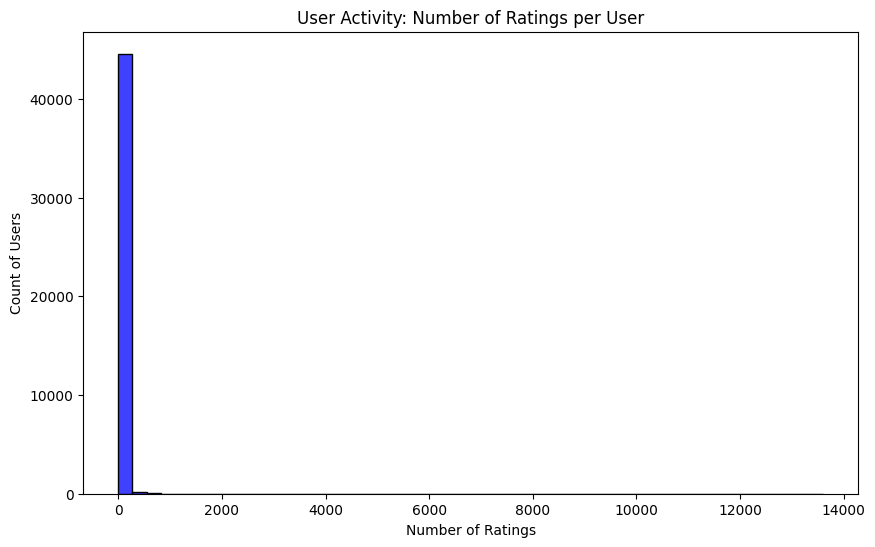

In [10]:
user_activity = df['User-ID'].value_counts()
book_activity = df['ISBN'].value_counts()

print('\
User Activity Statistics:')
print('Average ratings per user:', round(len(df) / df['User-ID'].nunique(), 2))
print('Median ratings per user:', user_activity.median())
print('Max ratings by a single user:', user_activity.max())

user_activity = df['User-ID'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=50, kde=False, color='blue')
plt.title('User Activity: Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()


Book Activity Statistics:
Average ratings per book: 2.44
Median ratings per book: 1.0
Max ratings for a single book: 1058


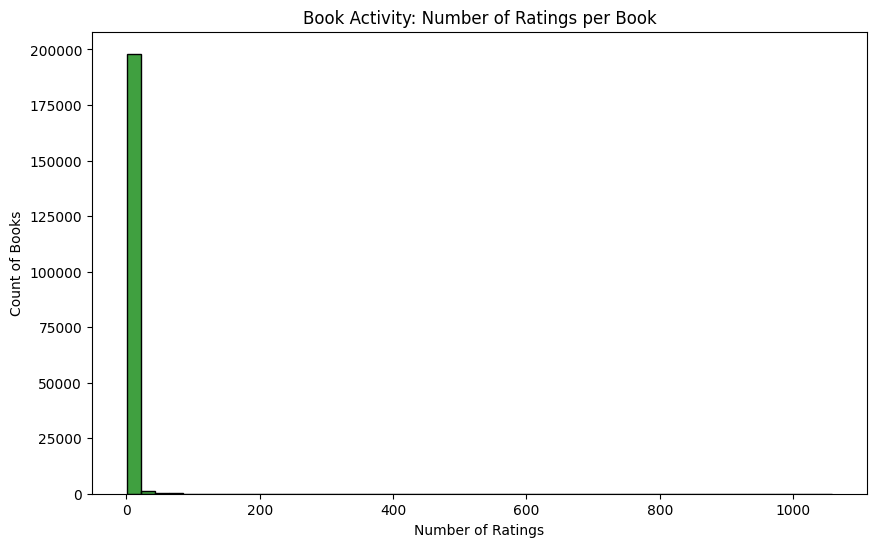

In [11]:
print('\
Book Activity Statistics:')
print('Average ratings per book:', round(len(df) / df['ISBN'].nunique(), 2))
print('Median ratings per book:', book_activity.median())
print('Max ratings for a single book:', book_activity.max())

book_activity = df['ISBN'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(book_activity, bins=50, kde=False, color='green')
plt.title('Book Activity: Number of Ratings per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Books')
plt.show()

In [12]:
# Check for missing values
print('\
Missing Values:')
print(df.isnull().sum())

Missing Values:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [13]:
from sklearn.preprocessing import LabelEncoder


In [14]:
le = LabelEncoder()
df['ISBN_encoded'] = le.fit_transform(df['ISBN'])

In [15]:
min_user_ratings = 5 #setting a threshold value for user rating per user here
min_book_ratings = 5

In [16]:
user_activity = df['User-ID'].value_counts()
active_users = user_activity[user_activity >= min_user_ratings].index
df_filtered = df[df['User-ID'].isin(active_users)]

In [17]:
book_activity = df_filtered['ISBN'].value_counts()
active_books = book_activity[book_activity >= min_book_ratings].index
df_filtered = df_filtered[df_filtered['ISBN'].isin(active_books)]

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_filtered['Book-Rating-Normalized'] = scaler.fit_transform(df_filtered[['Book-Rating']])


In [19]:
print(df_filtered.head())
print('\
Remaining Users:', df_filtered['User-ID'].nunique())
print('Remaining Books:', df_filtered['ISBN'].nunique())
print('Remaining Ratings:', len(df_filtered))

    User-ID        ISBN  Book-Rating  ISBN_encoded  Book-Rating-Normalized
10   276746   425115801            0         91163                     0.0
11   276746   449006522            0        100988                     0.0
12   276746   553561618            0        117727                     0.0
13   276746  055356451X            0          6832                     0.0
15   276746   786014512            0        157250                     0.0
Remaining Users: 9055
Remaining Books: 15417
Remaining Ratings: 196249


In [20]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357277 sha256=b0dda9d9fec836b2525f55f7e6acf6cc38006840d40136c99e77d8448cd456ca
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [21]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


In [22]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_filtered[['User-ID', 'ISBN', 'Book-Rating']], reader)

In [23]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [24]:
svd_model = SVD()
svd_model.fit(trainset)

In [25]:
predictions = svd_model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print('SVD Model Evaluation:')
print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 3.5715
MAE:  2.9111
SVD Model Evaluation:
RMSE: 3.5714822749519652
MAE: 2.9111047817036795


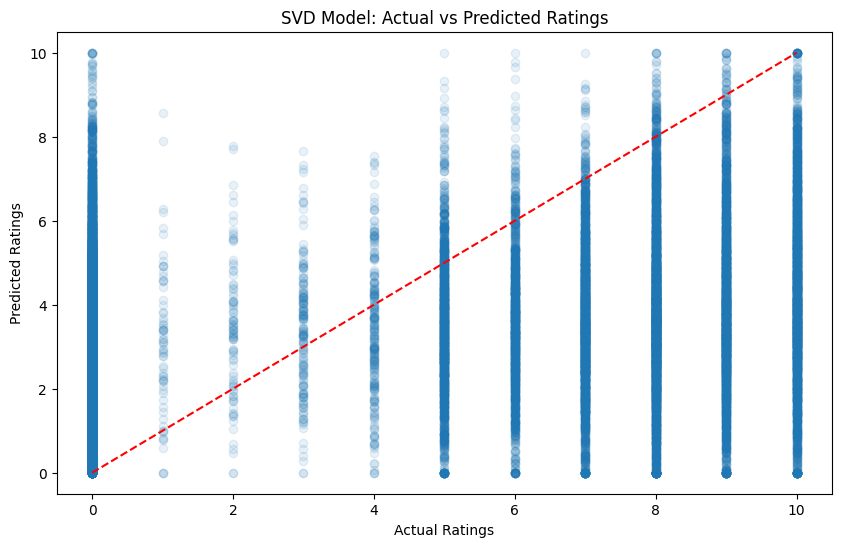

In [26]:
actual_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]

plt.figure(figsize=(10, 6))
plt.scatter(actual_ratings, predicted_ratings, alpha=0.1)
plt.plot([0, 10], [0, 10], 'r--')  # Perfect prediction line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('SVD Model: Actual vs Predicted Ratings')
plt.show()

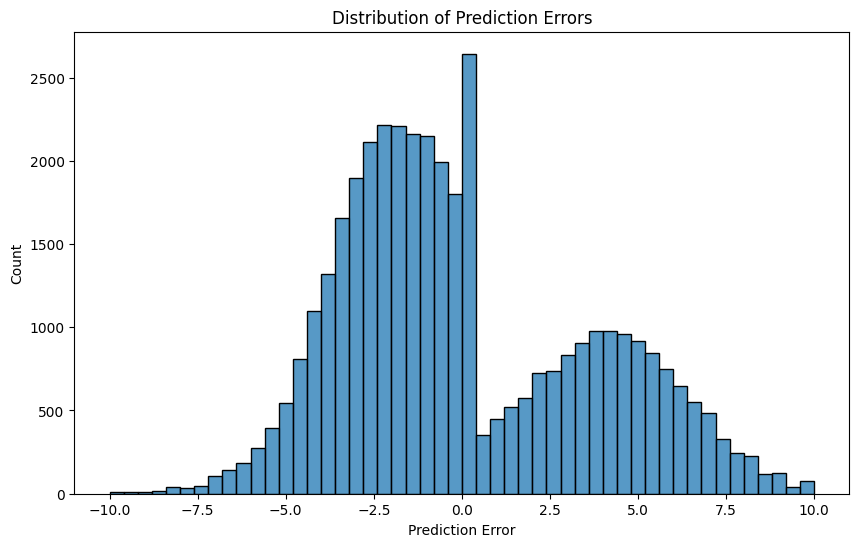

In [27]:
errors = [pred.r_ui - pred.est for pred in predictions]
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.show()

In [28]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
import pandas as pd

#optimizing as error in prediction

#  GridSearchCV
param_grid = {
    'n_factors': [20, 50, 100],  # Number of latent factors
    'reg_all': [0.02, 0.05, 0.1],  # Regularization term
    'lr_all': [0.002, 0.005, 0.01]  # Learning rate for gradient descent
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
grid_search.fit(data)

# Extract the best parameters and model
best_params = grid_search.best_params['rmse']
best_model = grid_search.best_estimator['rmse']

best_params


{'n_factors': 20, 'reg_all': 0.1, 'lr_all': 0.002}

In [29]:
from surprise import SVD

# Initialize the model with the best parameters
final_model = SVD(n_factors=20, reg_all=0.1, lr_all=0.002)

# Train the model on the entire dataset
trainset = data.build_full_trainset()
final_model.fit(trainset)


In [30]:
final_model.fit(trainset)


In [31]:
predictions = final_model.test(testset)

rmse = accuracy.rmse(predictions)
print(f"Test RMSE: {rmse}")
mae = accuracy.mae(predictions)
print(f"Test MAE: {mae}")

RMSE: 3.1480
Test RMSE: 3.147972638681482
MAE:  2.6580
Test MAE: 2.6579629542161713


In [32]:
# Analyze predictions
for pred in predictions[:5]:  # Display the first 5 predictions
    print(f"User: {pred.uid}, Item: {pred.iid}, Actual: {pred.r_ui}, Predicted: {pred.est}")


User: 91832, Item: 312980140, Actual: 0.0, Predicted: 1.3593967011791244
User: 48046, Item: 316666343, Actual: 0.0, Predicted: 2.9174765548572017
User: 85757, Item: 671882368, Actual: 0.0, Predicted: 2.0543360209481745
User: 85701, Item: 812563581, Actual: 0.0, Predicted: 0.6402234971011406
User: 24945, Item: 3404130014, Actual: 0.0, Predicted: 2.7714761341777026


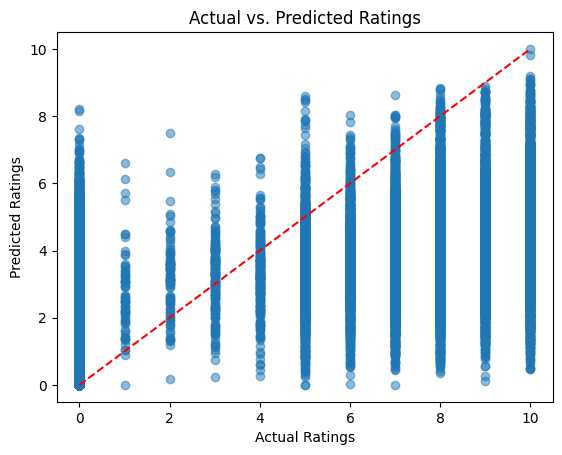

In [33]:
import matplotlib.pyplot as plt

# Extract actual and predicted ratings
actual = [pred.r_ui for pred in predictions]
predicted = [pred.est for pred in predictions]

plt.scatter(actual, predicted, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')  # Reference line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.show()


# Using neural network


In [34]:
!pip install tensorflow


In [35]:
import tensorflow as tf
from tensorflow.keras import mixed_precision


In [36]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [37]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [39]:
print(df.head())

   User-ID        ISBN  Book-Rating  ISBN_encoded
0   276725  034545104X            0          2817
1   276726   155061224            5         19375
2   276727   446520802            0         99232
3   276729  052165615X            3          6222
4   276729   521795028            6        111452


In [41]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [43]:
train_users = train_data['User-ID'].values
train_books = train_data['ISBN_encoded'].values
train_ratings = train_data['Book-Rating'].values

test_users = test_data['User-ID'].values
test_books = test_data['ISBN_encoded'].values
test_ratings = test_data['Book-Rating'].values

In [44]:
class NCF(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_dim)
        self.book_embedding = tf.keras.layers.Embedding(num_books, embedding_dim)
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(64, activation='relu')
        self.fc3 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        user, book = inputs
        user_emb = self.user_embedding(user)
        book_emb = self.book_embedding(book)
        x = tf.concat([user_emb, book_emb], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)

In [47]:
num_users = train_data['User-ID'].nunique()
num_books = train_data['ISBN_encoded'].nunique()
embedding_dim = 64

model = NCF(num_users, num_books, embedding_dim)

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error')

In [49]:
history = model.fit(
    [train_users, train_books], train_ratings,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 14.9222 - val_loss: 14.3590
Epoch 2/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 10.7226 - val_loss: 16.0663
Epoch 3/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 8.9054 - val_loss: 16.5504
Epoch 4/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 7.8129 - val_loss: 16.9305
Epoch 5/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 7.3559 - val_loss: 17.3225
Epoch 6/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 7.0182 - val_loss: 17.1820
Epoch 7/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 6.7785 - val_loss: 17.6989
Epoch 8/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 6.6029 - val_loss: 17.3596
Epoch 9/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 6.4170 - val_loss: 17.8795
Epoch 10/10
4881/4881 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 6.2788 - val_loss: 18.0532


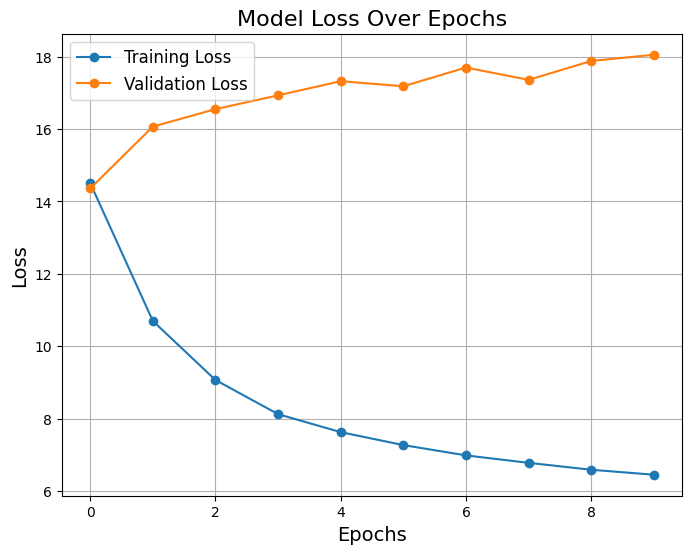

In [50]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [52]:
import numpy as np
ncf_mse = model.evaluate([test_users, test_books], test_ratings, verbose=0)
ncf_rmse = np.sqrt(ncf_mse)

print(f"NCF MSE: {ncf_mse}")
print(f"NCF RMSE: {ncf_rmse}")


NCF MSE: 17.972660064697266
NCF RMSE: 4.239417420436122


In [56]:
from sklearn.metrics import accuracy_score
predicted_ratings = model.predict([test_users, test_books])
threshold = 3
predicted_binary = (predicted_ratings >= threshold).astype(int)
true_binary = (test_ratings >= threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(true_binary, predicted_binary)
predicted_rounded = np.round(predicted_ratings)

accuracy = accuracy_score(test_ratings, predicted_rounded)
print(f"NCF Accuracy (Exact Match): {accuracy}")


3051/3051 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
NCF Accuracy (Exact Match): 0.16947867686980753


In [59]:
# Store RMSE and MAE for both models
results = {
    "Model": ["SVD", "NCF"],
    "RMSE": [rmse, ncf_rmse],
    "MAE": [mae, ncf_mse]
}

# Create a DataFrame for visualization
import pandas as pd
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)


  Model      RMSE        MAE
0   SVD  3.147973   2.657963
1   NCF  4.239417  17.972660


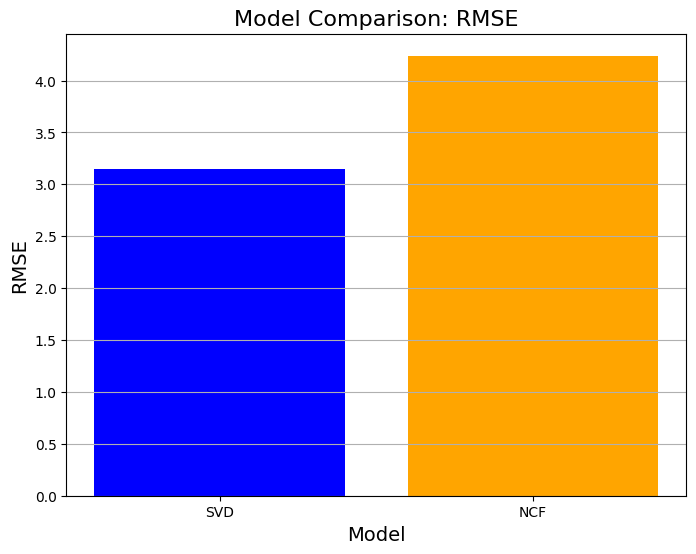

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(results_df["Model"], results_df["RMSE"], color=['blue', 'orange'])
plt.title("Model Comparison: RMSE", fontsize=16)
plt.ylabel("RMSE", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.grid(axis='y')
plt.show()


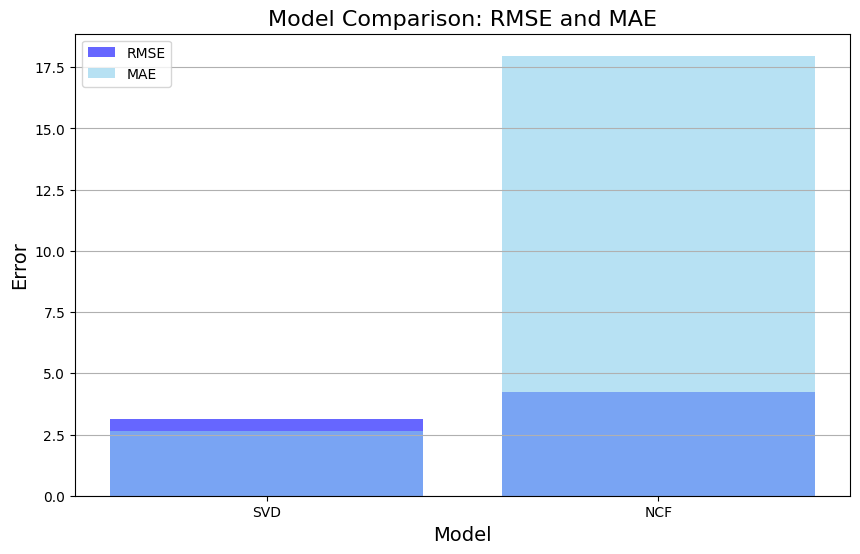

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(results_df["Model"], results_df["RMSE"], color='blue', alpha=0.6, label='RMSE')

ax.bar(results_df["Model"], results_df["MAE"], color='skyblue', alpha=0.6, label='MAE')

ax.set_title("Model Comparison: RMSE and MAE", fontsize=16)
ax.set_ylabel("Error", fontsize=14)
ax.set_xlabel("Model", fontsize=14)

ax.legend()
plt.grid(axis='y')
plt.show()
